In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  
import numpy as np

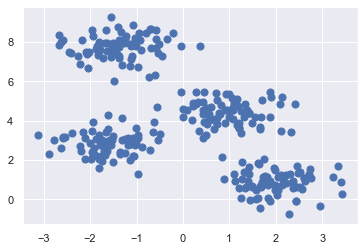

In [5]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

## K-means

### The Algorithm

1. Randomly choose $k$ centroids $C = \{c_1, c_2, \dots, c_k\}$ from the data points $X = \{x_1, x_2, \dots, x_n\} \in \mathbb{R}^D $.
2. For each data point $x_i$, find the nearest centroid $c_j$ as its corresponding cluster using *sum of squared distance* $ D(x_i, c_j) = \displaystyle\sum_{i=1}^{n}{\| x_i - c_j \|^2}$.
3. For each cluster, update its centroid by computing means value along the dimension of data points in the cluster.
4. Compute the displacement between the old and the new centroids and repeat steps 2 and 3 if the displacement is less than a threshold (converged).

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

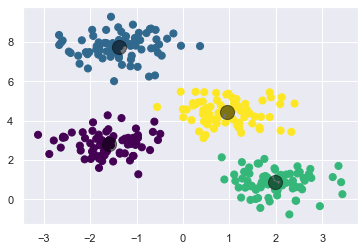

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Text(0.98, 0.98, 'Final Clustering')

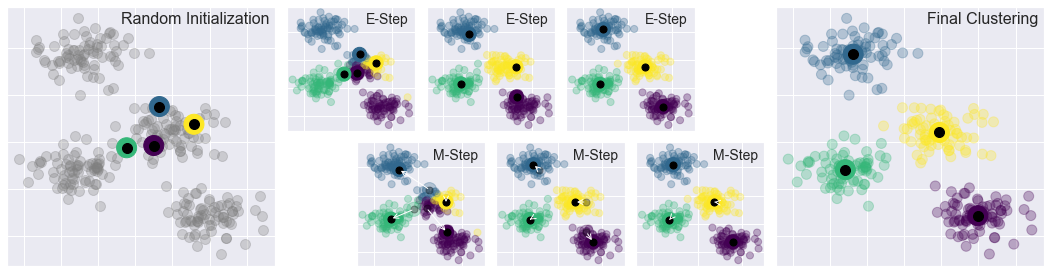

In [9]:
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)

## How to choose a right number of clusters

### Solution: Measuring Cluster Quality to Determine the Number of Clusters


#### Supervised method
*Homogeneity*: Each cluster contains only members of a single class.

*Completeness*: All members of a given class are assigned to the same cluster.

#### Unsupervised method

*Sihouette Coefficient*: Evaluate how well the **compactness** and the **separation** of the clusters are.
(Note that the notation below is consistent with the above content.) Using *Sihouette Coefficient*, we can choose an optimal value for number of clusters.

***

$ a(x_i) $ denotes the **mean intra-cluster distance**. Evaluate the compactness of the cluster to which $x_i$ belongs. (The smaller the more compact)

$$ a(x_i) = \frac{ \sum_{x_k \in C_j ,\ k \neq i}{D(x_i, x_k)} }{\left\vert C_j \right\vert - 1} $$  

For the data point $x_i$, caculate its average distance to all the other data points in its cluster. (Minusing one in denominator part is to leave out the current data point $x_i$)

***

$ b(x_i) $ denotes the **mean nearest-cluster distance**. Evaluate how $x_i$ is separated from other clusters. (The larger the more separated)

$$ b(x_i) = \min_{C_j :\ 1 \leq j \leq k ,\ x_i \notin C_j} \left\{ \frac{ \sum_{x_k \in C_j}{D(x_i, x_k)} }{\left\vert C_j \right\vert } \right\} $$

For the data point $x_i$ and all the other clusters not containing $x_i$, caculate its average distance to all the other data points in the given clusters. Find the minimum distance value with respect to the given clusters. 

***

Finally, *Silhouette Coefficient*: $ s(x_i) = \displaystyle\frac{b(x_i) - a(x_i)}{\max\{a(x_i), b(x_i)\}},\ -1 \leq s(x_i) \leq 1 $. Want $a(x_i) \lt b(x_i)$ and $a(x_i) \to 0$ so as to $s(x_i) \to 1$.

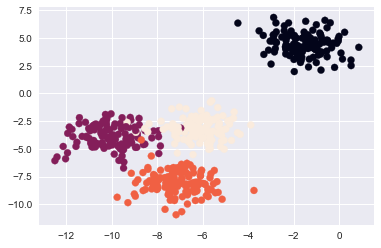

In [6]:
# Generate data.
# This particular setting has one distinct cluster and 3 clusters placed close together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)

# Plot the data distribution.
plt.scatter(X[:,0], X[:,1], c=y)

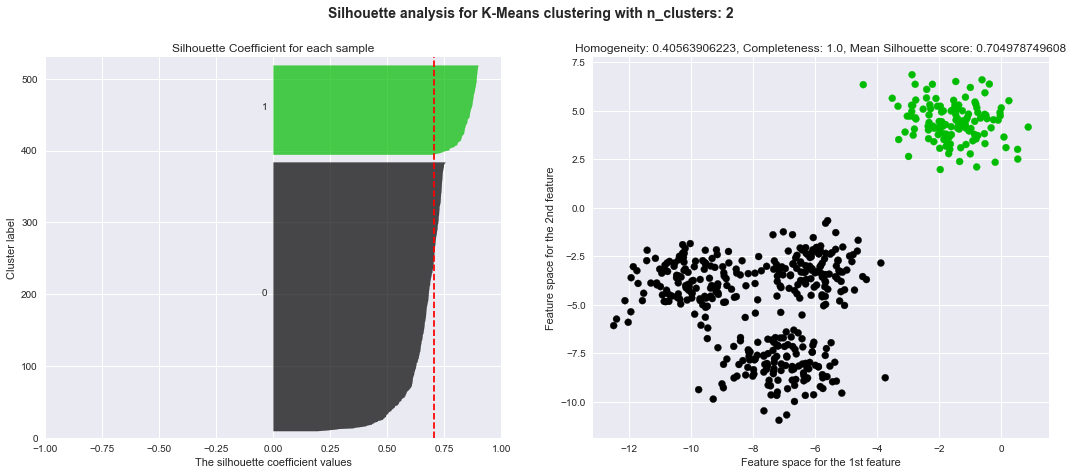

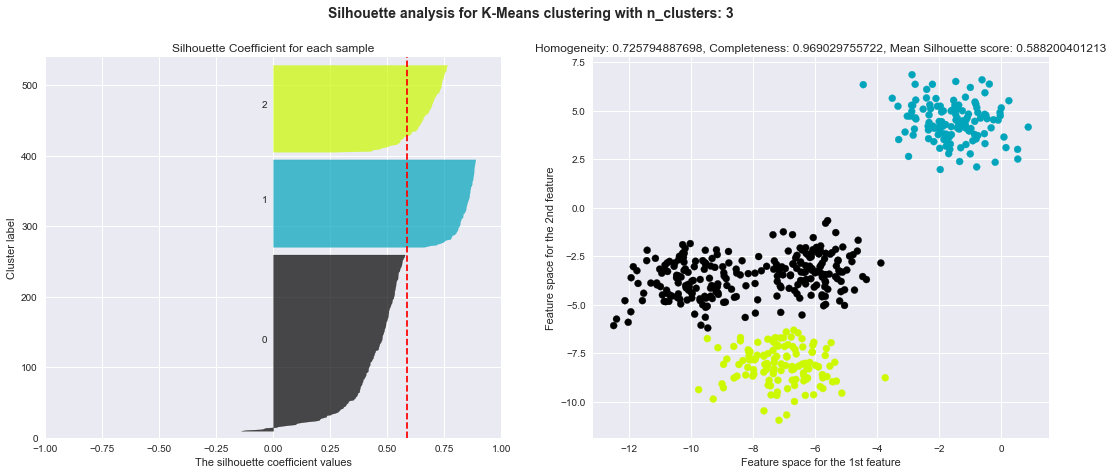

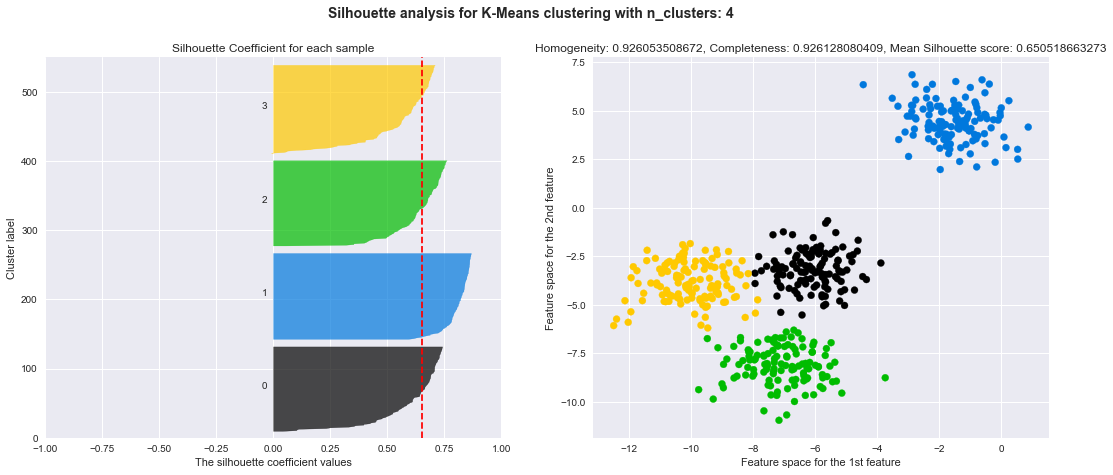

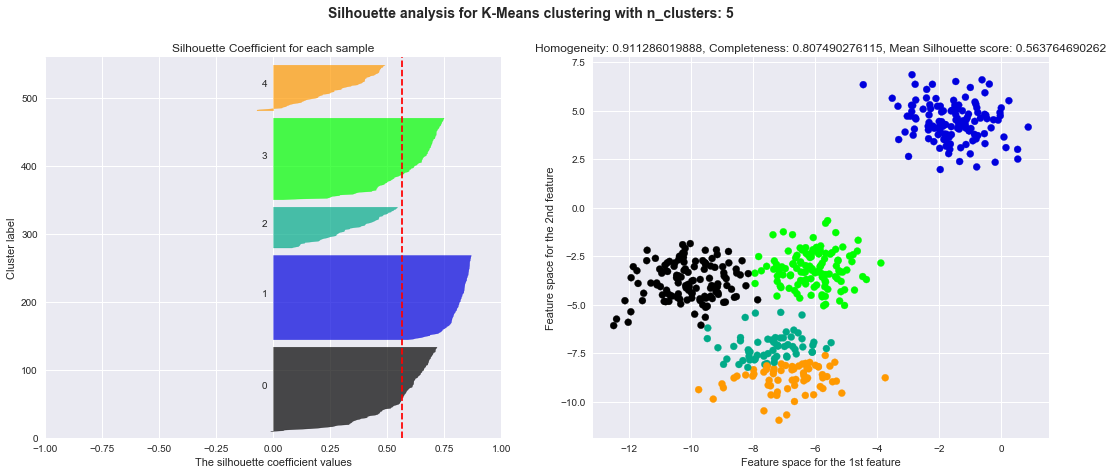

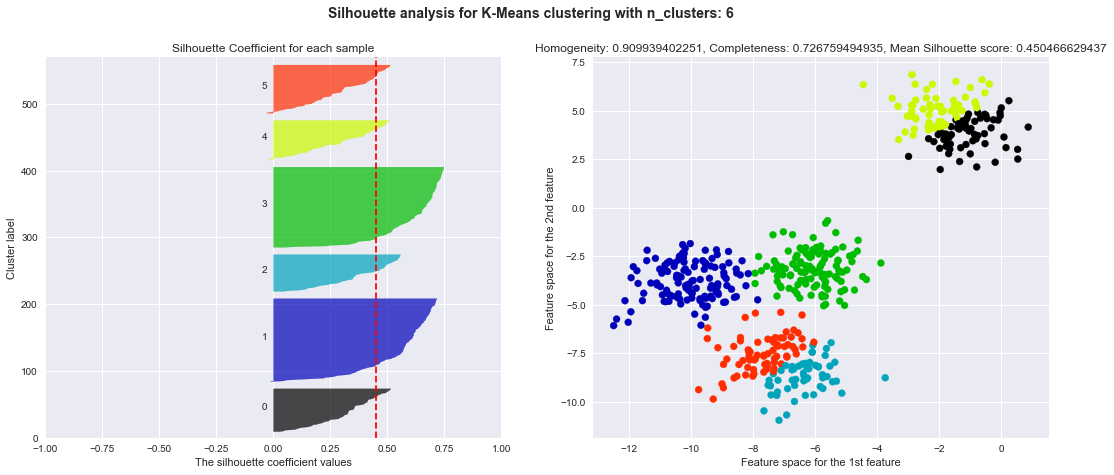

In [7]:
from sklearn import metrics # for evaluations
import matplotlib.cm as cm
from scipy.spatial.distance import cdist

# List of number of clusters
range_n_clusters = [2, 3, 4, 5, 6]

meandist = []

# For each number of clusters, perform Silhouette analysis and visualize the results.
for n_clusters in range_n_clusters:
    
    # Perform k-means.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    y_pred = kmeans.fit_predict(X)
    
    # Compute the cluster homogeneity and completeness.
    homogeneity = metrics.homogeneity_score(y, y_pred)
    completeness = metrics.completeness_score(y, y_pred)
    
    # Compute the Silhouette Coefficient for each sample.
    s = metrics.silhouette_samples(X, y_pred)
    
    # Compute the mean Silhouette Coefficient of all data points.
    s_mean = metrics.silhouette_score(X, y_pred)
    
    meandist.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1))/X.shape[0])
    
    # For plot configuration -----------------------------------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Configure plot.
    plt.suptitle('Silhouette analysis for K-Means clustering with n_clusters: {}'.format(n_clusters),
                 fontsize=14, fontweight='bold')
    
    # Configure 1st subplot.
    ax1.set_title('Silhouette Coefficient for each sample')
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # Configure 2st subplot.
    ax2.set_title('Homogeneity: {}, Completeness: {}, Mean Silhouette score: {}'.format(homogeneity,
                                                                                        completeness,
                                                                                        s_mean))
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    # For 1st subplot ------------------------------------------------------------------------------------------
    
    # Plot Silhouette Coefficient for each sample
    y_lower = 10
    for i in range(n_clusters):
        ith_s = s[y_pred == i]
        ith_s.sort()
        size_cluster_i = ith_s.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_s,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        
    # Plot the mean Silhouette Coefficient using red vertical dash line.
    ax1.axvline(x=s_mean, color="red", linestyle="--")
    
    # For 2st subplot -------------------------------------------------------------------------------------------
    
    # Plot the predictions
    colors = cm.spectral(y_pred.astype(float) / n_clusters)
    ax2.scatter(X[:,0], X[:,1], c=colors)

The silhouette plot shows that the `n_clusters` value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with above average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4.

Text(0.5,1,u'Selecting k with the Elbow Method')

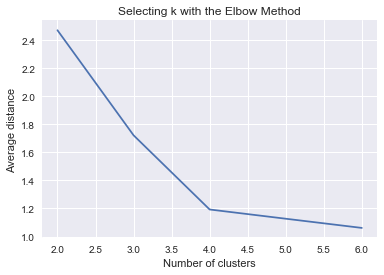

In [8]:
# Plot average distance from observations from the cluster centroid
# to use the Elbow Method to identify number of clusters to choose
plt.plot(range_n_clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method') 

## Nonlinear cluster boundaries

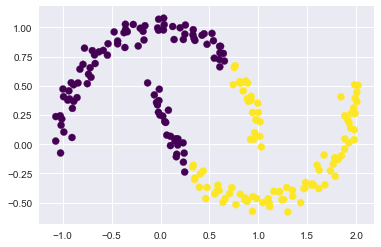

In [9]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

C:\Users\mikhail\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


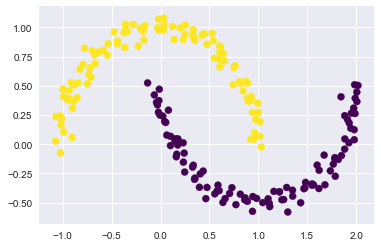

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### "Classification" with no classes

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797L, 64L)

In [12]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10L, 64L)

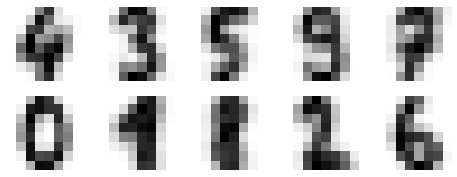

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [14]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

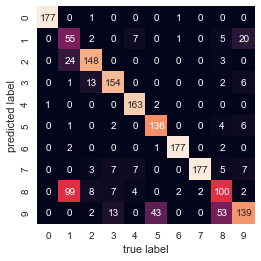

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');